# KODEX은행지수 예측 모델

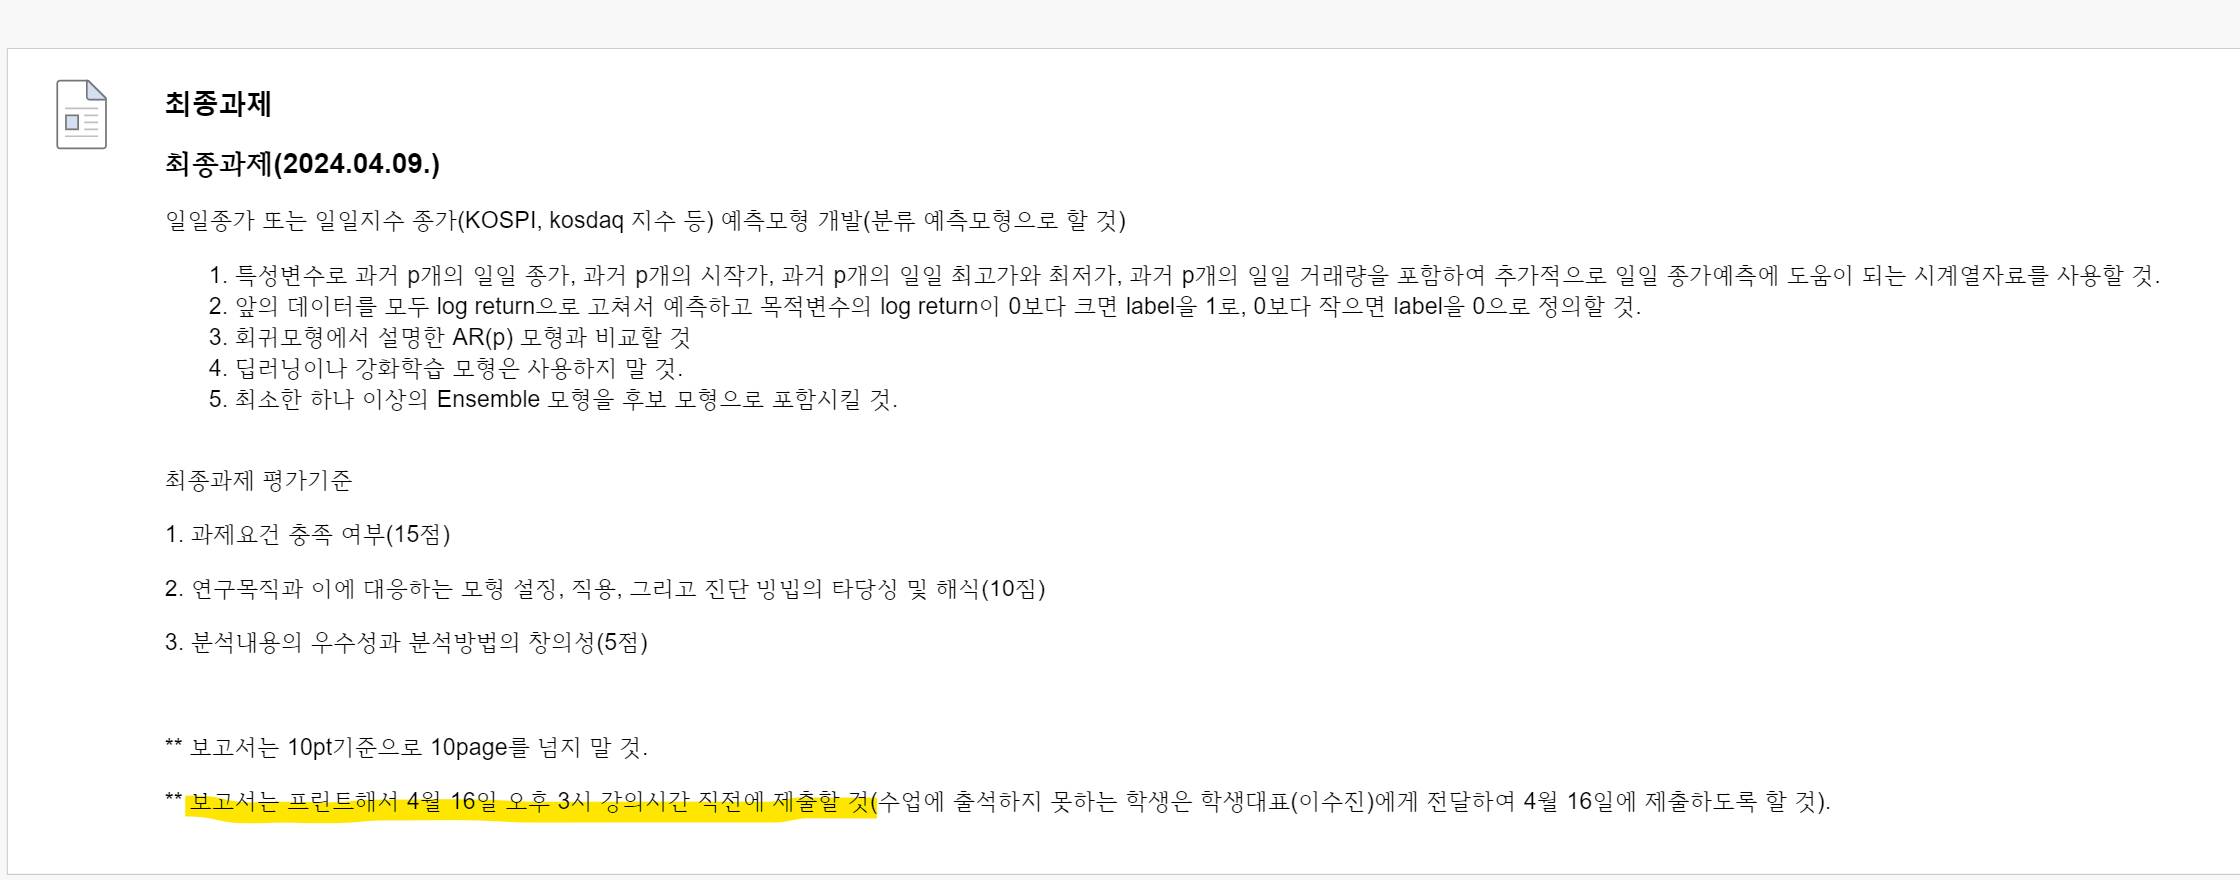

내가 이해한거는 목적변수 (종가든 시작가든 상관없댔음)를 전날 대비 올랐는지 log return(즉 수익률) 파생변수를 하나만들고, 이거가 전날보다 올랐으면 (0보다크면)1 이고, 전날보다 내려갔으면(0보다작으면) 0 으로 레이블링하라는 거같오 ,근데 전날에 데이터가 없다면 그전전날 데이터로 끌어오는 코드도 고려해라 요런식..

# KODEX 은행 데이터 불러오기

In [1]:
!pip install pykrx

In [2]:
from pykrx import stock
from pykrx import bond

In [3]:
from pykrx import stock
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

#The line `tickers = stock.get_etf_ticker_list("20201119")` is calling a function `get_etf_ticker_list` from the `stock` module in the `pykrx` library. This function is used to retrieve a list of ETF tickers that were valid on the specified date "20201119". The function returns the list of ETF tickers, which is then converted into a DataFrame with a column named '종목코드'.
tickers = stock.get_etf_ticker_list("20201119")
tickers=pd.DataFrame(tickers,columns=['종목코드'])

url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])
df=df[['itemcode','itemname']]
df=df.rename(columns={"itemcode": "종목코드", "itemname": "종목명"})

etf=pd.merge(left=tickers,right=df,how='left',on='종목코드' )
bank_etf=etf[etf['종목명'].str.contains('은행')][1:]

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\1397452333.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(json_data['result']['etfItemList'])


In [4]:
bank_etf

,종목코드,종목명
272,091170,KODEX 은행


In [5]:
# KODEX 은행 기간 설정 #"20131227"부터 "20240412"까지로 설정 #실제로는 20140101~20240412까지할거임
df_kodex = stock.get_etf_ohlcv_by_date("20131227", "20240412", '091170')
print(df_kodex.head())

                NAV    시가    고가    저가    종가     거래량        거래대금    기초지수
날짜                                                                     
2013-12-27  8359.52  8280  8335  8240  8335    6021    50096690  836.79
2013-12-30  8526.02  8335  8540  8335  8540   26560   225016795  853.67
2014-01-02  8486.64  8595  8680  8410  8490  118777  1014985790  849.67
2014-01-03  8225.64  8425  8435  8220  8235   16046   132756530  823.30
2014-01-06  8239.39  8255  8325  8160  8235    5639    46433115  824.71


In [6]:
df_kodex.tail() # KODEX 데이터

#시가	고가	저가	종가	거래량	4개만 필요할듯

,NAV,시가,고가,저가,종가,거래량,거래대금,기초지수
날짜,,,,,,,,
2024-04-05,7982.42,7950,8075,7935,7985,393780,3159634290,777.91
2024-04-08,8064.02,8000,8130,7980,8055,748528,6039808695,786.36
2024-04-09,7996.32,8085,8140,7985,8030,423717,3406776395,779.38
2024-04-11,7935.16,7635,7985,7625,7920,1055072,8268238985,773.08
2024-04-12,7674.79,7870,7905,7640,7660,1138940,8777506815,746.13


## log return 만들기
log return 과 return의 차이비교필요

### return 값 생성

In [57]:
df_kodex_close= (df_kodex['종가']/df_kodex['종가'].shift(1)-1)*100 #위 수식 코드로 구현

df_kodex_close #전날 대비 수익률

#return으로 변경하고 merge하기

날짜
2013-12-27         NaN
2013-12-30    2.459508
2014-01-02   -0.585480
2014-01-03   -3.003534
2014-01-06    0.000000
                ...   
2024-04-05   -0.930521
2024-04-08    0.876644
2024-04-09   -0.310366
2024-04-11   -1.369863
2024-04-12   -3.282828
Name: 종가, Length: 2531, dtype: float64

In [58]:
df_kodex = df_kodex[['시가','고가','저가','종가','거래량']]
df_kodex

,시가,고가,저가,종가,거래량
날짜,,,,,
2013-12-27,8280,8335,8240,8335,6021
2013-12-30,8335,8540,8335,8540,26560
2014-01-02,8595,8680,8410,8490,118777
2014-01-03,8425,8435,8220,8235,16046
2014-01-06,8255,8325,8160,8235,5639
...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780
2024-04-08,8000,8130,7980,8055,748528
2024-04-09,8085,8140,7985,8030,423717


In [59]:
df_kodex.copy()

,시가,고가,저가,종가,거래량
날짜,,,,,
2013-12-27,8280,8335,8240,8335,6021
2013-12-30,8335,8540,8335,8540,26560
2014-01-02,8595,8680,8410,8490,118777
2014-01-03,8425,8435,8220,8235,16046
2014-01-06,8255,8325,8160,8235,5639
...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780
2024-04-08,8000,8130,7980,8055,748528
2024-04-09,8085,8140,7985,8030,423717


In [82]:
# Merge df_kodex and df_kodex_close on '날짜'
merged_df = df_kodex.merge(df_kodex_close, left_index=True, right_index=True, how='left')
merged_df

,시가,고가,저가,종가_x,거래량,종가_y
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,2.459508
2014-01-02,8595,8680,8410,8490,118777,-0.585480
2014-01-03,8425,8435,8220,8235,16046,-3.003534
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.930521
2024-04-08,8000,8130,7980,8055,748528,0.876644
2024-04-09,8085,8140,7985,8030,423717,-0.310366


In [ ]:
# 데이터프레임 merged_df의 모든 컬럼을 float으로 변환
for column in merged_df.columns:
    merged_df[column] = merged_df[column].astype(float)

In [83]:
#칼럼명 변경
merged_df.rename(columns={'종가_x': '종가','종가_y':'return'}, inplace=True)
merged_df

,시가,고가,저가,종가,거래량,return
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,2.459508
2014-01-02,8595,8680,8410,8490,118777,-0.585480
2014-01-03,8425,8435,8220,8235,16046,-3.003534
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.930521
2024-04-08,8000,8130,7980,8055,748528,0.876644
2024-04-09,8085,8140,7985,8030,423717,-0.310366


### log_return (로그 변동률) 생성
merged_df['return'] + 1이 0이 되면, np.log(0)은 정의되지 않아 NaN이 됩니다.->이거는 수익률구할때

In [89]:
import numpy as np
df_kodex_close_log= np.log(df_kodex['종가']/df_kodex['종가'].shift(1)) #위 수식 코드로 구현

df_kodex_close_log #전날 대비 수익률 log

# shift(1) 함수는 각 가격을 하나씩 위로 이동시켜, 각 시점의 가격과 바로 이전 시점의 가격을 비교할 수 있게 합니다.
#log_return으로 변경하고 merge하기

날짜
2013-12-27         NaN
2013-12-30    0.024297
2014-01-02   -0.005872
2014-01-03   -0.030496
2014-01-06    0.000000
                ...   
2024-04-05   -0.009349
2024-04-08    0.008728
2024-04-09   -0.003108
2024-04-11   -0.013793
2024-04-12   -0.033379
Name: 종가, Length: 2531, dtype: float64

In [90]:
# Merge df_kodex and df_kodex_close on '날짜'
merged_df = merged_df.merge(df_kodex_close_log, left_index=True, right_index=True, how='left')
merged_df

,시가,고가,저가,종가_x,거래량,종가_y
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,0.024297
2014-01-02,8595,8680,8410,8490,118777,-0.005872
2014-01-03,8425,8435,8220,8235,16046,-0.030496
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.009349
2024-04-08,8000,8130,7980,8055,748528,0.008728
2024-04-09,8085,8140,7985,8030,423717,-0.003108


In [94]:
merged_df.rename(columns={'종가_x': '종가','종가_y':'log_return'}, inplace=True)

In [95]:
merged_df.head()

,시가,고가,저가,종가,거래량,log_return
날짜,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000


In [93]:
merged_df.dtypes

시가      float64
고가      float64
저가      float64
종가_x    float64
거래량     float64
종가_y    float64
dtype: object

In [96]:
merged_df.head(30)

,시가,고가,저가,종가,거래량,log_return
날짜,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280
2014-01-09,8180.0,8340.0,8180.0,8290.0,7646.0,0.011526
2014-01-10,8225.0,8270.0,8085.0,8090.0,11189.0,-0.024421


### 목적변수 target 컬럼 생성

In [97]:
merged_df['target'] = (merged_df['log_return'] > 0).astype(int)

merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN,0
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297,1
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


### 이거는 fdr로 불러올때...

In [14]:
# df_index_list = fdr.SnapDataReader('KRX/INDEX/LIST') # KRX 전체 지수목록
# df_index_list

# 데이터 시각화

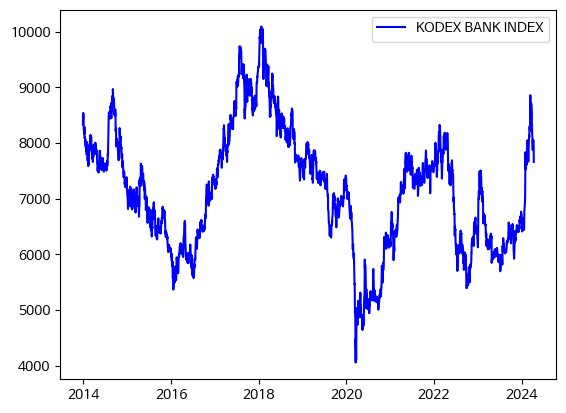

In [100]:
import matplotlib.pyplot as plt
plt.plot(merged_df.index,merged_df.종가,'b',label='KODEX BANK INDEX')
plt.legend(loc='best')
plt.show()

#코로나로 인해 2020년에 은행 index에 극심한 변화가 있었음을 알 수 있음

# 파생변수
- cofix
- 환율
- 국내금리
- 기준금리

## 1. 코픽스 변수 데이터 불러오기
- 변수선택이유: 신규취급액의 경우 한 달 동안의 금리를 평균으로 산출하기 때문에 시장금리에 민감하게 반응합니다. 상승도 하강도 거의 즉각 반응한다고 보셔도 무리가 없습니다.  
  -> 같은 논리로 단기 cofix는 주간의 금리를 평균으로 산출

In [16]:
# import requests
# year = 2013
# url = f'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W={year}&BasicYear={year}'
# headers = {
#     'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
#     'Accept-Encoding': 'gzip, deflate, br',
#     'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
#     'Host': 'portal.kfb.or.kr',
#     'Referer': 'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W=&BasicYear=2022',
#     'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Whale/3.21.192.22 Safari/537.36',
# }
# res = requests.get(url, headers=headers)
# res.encoding = 'euc-kr'
# res.text

In [17]:
# import pandas as pd
# df_cofix = pd.read_html(res.text)
# df_cofix

In [18]:
import requests
import pandas as pd

def get_cofix_tables(year):
    url = f'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W={year}&BasicYear={year}'
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        'Host': 'portal.kfb.or.kr',
        'Referer': 'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W=&BasicYear=2024',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Whale/3.21.192.22 Safari/537.36',
    }
    res = requests.get(url, headers=headers)
    res.encoding = 'euc-kr'
    return pd.read_html(res.text)

df_cofix = pd.DataFrame() 
df_cofix_short = pd.DataFrame()

for year in range(2013, 2025):
    dfs = get_cofix_tables(year)
    df_cofix = pd.concat([df_cofix, dfs[0]])
    df_cofix_short = pd.concat([df_cofix_short, dfs[1]])

## COFIX 변수 전처리.. (단기로 해야되나...?신규취급액이 나으려나,두개다해보기)
 1) 신규취급액기준 COFIX : 
 2)  단기코픽스 : CD를 대체해서 단기대출 지표금리로 쓰기 위해 만든 금리다. 시중은행 만기 3개월짜리 단기 조달 상품들의 최근 1주간 신규취급액에 대해 가중 평균한 지수다. 기존 코픽스와 달리 계약만기 3개월물인 단기자금만을 대상으로 한다.

### 1-1) 신규취급액기준 COFIX 전처리 및 컬럼 생성

In [19]:
df_cofix #대상월로 적용

,공시일,대상월,신규취급액기준 COFIX,잔액기준 COFIX,신 잔액기준 COFIX
0,2013/12/16,2013/11,2.60,2.91,NaN
1,2013/11/15,2013/10,2.62,2.94,NaN
2,2013/10/15,2013/09,2.63,2.99,NaN
3,2013/09/16,2013/08,2.62,3.02,NaN
4,2013/08/16,2013/07,2.63,3.06,NaN
...,...,...,...,...,...
10,2023/02/15,2023/01,3.82,3.63,3.02
11,2023/01/16,2022/12,4.29,3.52,2.92
0,2024/03/15,2024/02,3.62,3.81,3.24
1,2024/02/15,2024/01,3.66,3.84,3.29


In [ ]:
# if merged_df['날짜',mm] = df_cofix mm  :
#     left_index=True, right_index=True, how='left')

In [29]:
df_cofix = df_cofix[['대상월','신규취급액기준 COFIX']]
df_cofix

,대상월,신규취급액기준 COFIX
0,2013/11,2.60
1,2013/10,2.62
2,2013/09,2.63
3,2013/08,2.62
4,2013/07,2.63
...,...,...
10,2023/01,3.82
11,2022/12,4.29
0,2024/02,3.62
1,2024/01,3.66


In [ ]:
# 대상월 포맷 변경
df_cofix = pd.to_datetime(df_cofix['대상월'], format='%Y/%m').dt.to_period('M') #m을로 데이터ㅏ뽑기

# 데이터프레임을 '대상월'로 정렬 후 인덱스 재설정
df_cofix = df_cofix.sort_values('대상월').reset_index(drop=True)

df_cofix

In [39]:
df_cofix

,대상월,신규취급액기준 COFIX
0,2013-11,2.60
1,2013-10,2.62
2,2013-09,2.63
3,2013-08,2.62
4,2013-07,2.63
...,...,...
10,2023-01,3.82
11,2022-12,4.29
0,2024-02,3.62
1,2024-01,3.66


### 1-2) 단기 COFIX 전처리 및 컬럼생성

In [20]:
df_cofix_short.tail(30)
#대상기간에 적용

,공시일,대상기간,단기 COFIX
37,2023/04/12,2023/04/01 ~ 2023/04/07,3.47
38,2023/04/05,2023/03/25 ~ 2023/03/31,3.49
39,2023/03/29,2023/03/18 ~ 2023/03/24,3.48
40,2023/03/22,2023/03/11 ~ 2023/03/17,3.56
41,2023/03/15,2023/03/04 ~ 2023/03/10,3.55
42,2023/03/08,2023/02/25 ~ 2023/03/03,3.49
43,2023/03/02,2023/02/18 ~ 2023/02/24,3.55
44,2023/02/22,2023/02/11 ~ 2023/02/17,3.38
45,2023/02/15,2023/02/04 ~ 2023/02/10,3.44
46,2023/02/08,2023/01/28 ~ 2023/02/03,3.53


In [23]:
# 날짜 범위 생성 및 적용
df_cofix_short.copy()

date_range = []
for _, row in df_cofix_short.iterrows():
    start_date, end_date = row['대상기간'].split(' ~ ')
    dates = pd.date_range(start=start_date, end=end_date)
    date_range.extend([(date, row['단기 COFIX']) for date in dates])

# 새로운 데이터프레임 생성
df_cofix_short = pd.DataFrame(date_range, columns=['날짜', '단기 COFIX'])
df_cofix_short.sort_values(by='날짜', ascending=False, inplace=True)
df_cofix_short.reset_index(drop=True, inplace=True)

df_cofix_short

,날짜,단기 COFIX
0,2024-04-05,3.57
1,2024-04-04,3.57
2,2024-04-03,3.57
3,2024-04-02,3.57
4,2024-04-01,3.57
...,...,...
4095,2012-12-26,2.95
4096,2012-12-25,2.95
4097,2012-12-24,2.95
4098,2012-12-23,2.95


In [ ]:
df_cofix_short.set_index('날짜', inplace=True)

In [28]:
df_cofix_short.head(30)

,단기 COFIX
날짜,
2024-04-05,3.57
2024-04-04,3.57
2024-04-03,3.57
2024-04-02,3.57
2024-04-01,3.57
2024-03-31,3.57
2024-03-30,3.57
2024-03-29,3.60
2024-03-28,3.60


In [ ]:
# # Create a new DataFrame based on df1
# merged_df = merged_df.copy()
# merged_df['cofix_short'] = None  # Initialize the 단기 COFIX column

# # Function to find the 단기 COFIX value for each date in df1
# def find_cofix(date, df_cofix_short):
#     # Reverse iteration to find the first applicable 단기 COFIX value before the date
#     for idx in range(len(df_cofix_short) - 1, -1, -1):
#         if df_cofix_short.iloc[idx]['공시일'] <= date:
#             return df_cofix_short.iloc[idx]['단기 COFIX']
#     return None

# # Applying the function to populate the 단기 COFIX column in merged_df
# merged_df['cofix_short'] = merged_df.index.map(lambda x: find_cofix(x, df_cofix_short))

# merged_df

In [ ]:
# merged_df.head(30)

# 2. 환율 변수 
### 전처리 및 환율 컬럼생성

In [40]:
# Load the Excel file
df_change = pd.read_excel('C:/Users/chanyoung/Downloads/주요국 통화의 대원화 환율.xlsx')
df_change

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,주석,"1) 원/달러, 원/위안은 서울외국환시장 은행간 거래의 종가 기준2) 원/엔(하나은...",NaN,NaN
1,출처,ECOS,NaN,NaN
2,범례명,원/달러(좌축),원/100엔(좌축),원/위안(우축)
3,단위,(원),(원),(원)
4,주기,일,일,일
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [41]:
df_change.head(10)

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,주석,"1) 원/달러, 원/위안은 서울외국환시장 은행간 거래의 종가 기준2) 원/엔(하나은...",NaN,NaN
1,출처,ECOS,NaN,NaN
2,범례명,원/달러(좌축),원/100엔(좌축),원/위안(우축)
3,단위,(원),(원),(원)
4,주기,일,일,일
5,기간,1990-03-02 ~ 2024-04-12,2005-03-02 ~ 2024-04-12,2014-12-01 ~ 2024-04-12
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN


In [42]:
df_change= df_change[6:]
df_change

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN
10,1990-03-08,698.1,NaN,NaN
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [43]:
df_change.rename(columns={'주요국 통화의 대원화 환율': 'Date'}, inplace=True)

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\3889438914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change.rename(columns={'주요국 통화의 대원화 환율': 'Date'}, inplace=True)


In [44]:
df_change.rename(columns={'Unnamed: 1': '환율'}, inplace=True)
df_change

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\311575333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change.rename(columns={'Unnamed: 1': '환율'}, inplace=True)


,Date,환율,Unnamed: 2,Unnamed: 3
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN
10,1990-03-08,698.1,NaN,NaN
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [46]:
df_change = df_change[['Date','환율']]

In [48]:
df_change

<bound method NDFrame.describe of             Date      환율
6     1990-03-02     693
7     1990-03-05   695.1
8     1990-03-06   696.4
9     1990-03-07   697.6
10    1990-03-08   698.1
...          ...     ...
8439  2024-04-05  1352.8
8440  2024-04-08  1353.2
8441  2024-04-09  1354.9
8442  2024-04-11  1364.1
8443  2024-04-12  1375.4

[8438 rows x 2 columns]>

In [50]:
df_change.reindex(index=['Date'])
df_change

,Date,환율
6,1990-03-02,693
7,1990-03-05,695.1
8,1990-03-06,696.4
9,1990-03-07,697.6
10,1990-03-08,698.1
...,...,...
8439,2024-04-05,1352.8
8440,2024-04-08,1353.2
8441,2024-04-09,1354.9
8442,2024-04-11,1364.1


In [53]:
# 데이터프레임의 각 컬럼 데이터 타입 확인
df_change.dtypes #object 였음

Date    object
환율      object
dtype: object

In [54]:
# Date 칼럼을 datetime 형식으로 변환
df_change['Date'] = pd.to_datetime(df_change['Date'])
# Date 칼럼을 인덱스로 설정하고 데이터를 Date 순으로 정렬
df_change.set_index('Date', inplace=True)
df_change.sort_index(inplace=True)

df_change

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\1931714846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['Date'] = pd.to_datetime(df_change['Date'])


,환율
Date,
1990-03-02,693
1990-03-05,695.1
1990-03-06,696.4
1990-03-07,697.6
1990-03-08,698.1
...,...
2024-04-05,1352.8
2024-04-08,1353.2
2024-04-09,1354.9


In [ ]:
# 환율 컬럼을 float 타입으로 변환
df_change['환율'] = df_change['환율'].astype(float)

# 특정 날짜 범위로 데이터를 자르기
df_change = df_change.loc['2013-12-27':'2024-04-12']

In [56]:
df_change

,환율
Date,
2013-12-27,1053.9
2013-12-30,1055.4
2014-01-02,1050.3
2014-01-03,1055.2
2014-01-06,1065.4
...,...
2024-04-05,1352.8
2024-04-08,1353.2
2024-04-09,1354.9


### 한국은행기준금리 데이터
- 한국은행 경제 통계시스템 2013~20240411


In [ ]:
# df = df.transpose()	#행 열 전환
# df.rename(columns=df.iloc[0], inplace=True)	# 행열이 전환된 데이터프레임의 열 이름 제대로 수정
# df = df.drop(df.index[0])

In [149]:
df_base = pd.read_csv("C:/Users/chanyoung/Downloads/한국은행 기준금리 및 여수신금리_14090757.csv",encoding='utf-8')
df_base = df_base.transpose()	#행 열 전환
df_base

,0
통계표,1.3.1. 한국은행 기준금리 및 여수신금리
계정항목,한국은행 기준금리
단위,연%
변환,원자료
2013/01/01,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [150]:
df_base.rename(columns=df_base.iloc[1],inplace=True)
df_base

,한국은행 기준금리
통계표,1.3.1. 한국은행 기준금리 및 여수신금리
계정항목,한국은행 기준금리
단위,연%
2013/01/01,2.75
2013/01/02,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [152]:
df_base = df_base.iloc[3:]
df_base

,한국은행 기준금리
2013/01/01,2.75
2013/01/02,2.75
2013/01/03,2.75
2013/01/04,2.75
2013/01/05,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [153]:
#  인덱스 이름을 '날짜'로 변경
df_base = df_base.rename_axis('날짜')
df_base

,한국은행 기준금리
날짜,
2013/01/01,2.75
2013/01/02,2.75
2013/01/03,2.75
2013/01/04,2.75
2013/01/05,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5


In [157]:
# 인덱스를 날짜 형식으로 변환
df_base.index = pd.to_datetime(df_base.index)
df_base

,한국은행 기준금리
날짜,
2013-01-01,2.75
2013-01-02,2.75
2013-01-03,2.75
2013-01-04,2.75
2013-01-05,2.75
...,...
2024-04-07,3.5
2024-04-08,3.5
2024-04-09,3.5


In [101]:
merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN,0
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297,1
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


In [102]:
merged_df.copy()

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN,0
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297,1
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


In [103]:
# 2014-01-01부터 시작하도록 데이터 필터링
merged_df = merged_df[merged_df.index >= '2014-01-01']

# 데이터 확인
merged_df.head(), merged_df.shape

(                시가      고가      저가      종가       거래량  log_return  target
 날짜                                                                      
 2014-01-02  8595.0  8680.0  8410.0  8490.0  118777.0   -0.005872       0
 2014-01-03  8425.0  8435.0  8220.0  8235.0   16046.0   -0.030496       0
 2014-01-06  8255.0  8325.0  8160.0  8235.0    5639.0    0.000000       0
 2014-01-07  8200.0  8260.0  8160.0  8160.0   11565.0   -0.009149       0
 2014-01-08  8190.0  8260.0  8135.0  8195.0    7145.0    0.004280       1,
 (2529, 7))

# AR(p) 모형적용

In [105]:
#라이브러리 호출
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [106]:
# merged_df = merged_df.drop(columns=['moving_average_3'])
# merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


In [104]:
# # 3일 이동평균 추가
# merged_df['moving_average_3'] = merged_df['종가'].rolling(window=3).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\1495939700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['moving_average_3'] = merged_df['종가'].rolling(window=3).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트


,시가,고가,저가,종가,거래량,log_return,target,moving_average_3
날짜,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000
...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333


In [163]:
merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


### 시계열 데이터에서 train, validation, test 나누기
-> 보통회귀와는 다름

!조심하기!  

시계열 데이터는 window size만큼 들어가도록 input을 설계하는데, 이때 w사이즈 만큼의 input data가 train set 전체에 대해서 min-max 스케일링이 된 상태라면, 미래 시점의 데이터까지 같이 고려하여 스케일링이 되기 때문입니다. (절대 알 수 없는 미래 데이터가 개입 됨) trainset은 그렇다쳐도, 적어도!! testset에 대해서는 trainset에서 스케일링했던 통계 값으로 스케일링을 해주었어야 합니다. 
예전에 제가 주식 데이터를 다룰 때, 위 저자처럼 min-max 스케일링을 진행했다가 나중에 잘못됨을 느끼고, 생각보다 시계열 데이터에 대한 스케일링은 섬세해야 함을 깨달아 문제를 정의하게 되었고, 그것에 대해 실험하여 논문을 쓰게 되었습니다. 실험한 논문에 대한 글의 링크를 첨부합니다. 

https://inhovation97.tistory.com/71

In [120]:
# # 데이터 시간 순서대로 분할 ->그냥 train test val 로 나누면 시계열의 특성이 무시됨!!

# # 데이터의 70%, 15%, 15%로 분할하기
# n = len(merged_df)
# train_df = merged_df.iloc[:int(n*0.7)]
# val_df = merged_df.iloc[int(n*0.7):int(n*0.85)]
# test_df = merged_df.iloc[int(n*0.85):]

In [121]:
# 데이터셋 분할 ->shuffle=False를 줘야함! 그래야 밑둥부터
X = merged_df.drop(columns=["target"])
y = merged_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [122]:
# 모델 정의
ar_model = AutoReg(y_train, lags=1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [123]:
# AR(p) 모델 학습
ar_model_fitted = ar_model.fit()

In [124]:
# 앙상블 모델 학습
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [125]:
# 예측 및 성능 평가
y_pred_ar = ar_model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbm = gbm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [162]:
# 성능 메트릭 계산
metrics = {
    "AR(p)": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ar)),
        "MAE": mean_absolute_error(y_test, y_pred_ar)
    },
    "Random Forest": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        "MAE": mean_absolute_error(y_test, y_pred_rf)
    },
    "GBM": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gbm)),
        "MAE": mean_absolute_error(y_test, y_pred_gbm)
    },
    "XGBoost": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        "MAE": mean_absolute_error(y_test, y_pred_xgb)
    }
}

metrics
#변수 

{'AR(p)': {'RMSE': 0.4998938677036908, 'MAE': 0.49964380262201735},
 'Random Forest': {'RMSE': 0.0, 'MAE': 0.0},
 'GBM': {'RMSE': 1.3279121528522822e-05, 'MAE': 1.327226633116791e-05},
 'XGBoost': {'RMSE': 1.6225581989851685e-05, 'MAE': 1.621720580781696e-05}}

### 3일 이동평균 추가